# TODO:
- ile potrzeba iteracji (random seach, bayes) do uzyskania stabilncyh wyników
- trzeba się zastanowić jakie zakres hyper parametrów bierzemy
- określić i przeanalizować tunowalność CAŁYCH algorytmów
- sprawdić jak zmiana seed w random search wpływa na wyniki tunowalnośći (sampling bias)

### Imports

In [2]:
import itertools
import random
from typing import Any, Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas import DataFrame, Series
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from skopt import BayesSearchCV
from skopt.space import Integer, Real

from utills.dataset import load_dataset_from_id, split_dataset
from utills.pipeline import evaluate_pipeline_on_datasets, get_column_transformer, get_bayes_model

### Utill functions

In [4]:
def get_bayes_config(
    pipeline: Pipeline,
    search_space: Dict[str, Any],
    X: DataFrame,
    y: DataFrame,
    n_iter=100,
):
    opt: get_bayes_model(
        pipeline,
        search_space
    )
    opt.fit(X, y)
    return dict(opt.best_params_)

In [6]:
# def optimize_pipeline_over_params_combinations(
#     pipeline: Pipeline,
#     parameters_grid: List[dict],
#     X: DataFrame,
#     y: DataFrame,
#     X_val: DataFrame,
#     y_val: DataFrame,
# ) -> Pipeline:
#     # thats the teta^(j)*
#     best_score = float("-inf")
#     best_params = None

#     for params in parameters_grid:
#         # Update the pipeline parameters
#         pipeline_params = {f"{key}": value for key, value in params.items()}
#         pipeline.set_params(**pipeline_params)

#         pipeline.fit(X, y)
#         score = pipeline.score(X_val, y_val)

#         if score > best_score:
#             best_score = score
#             best_params = pipeline_params

#     pipeline.set_params(**best_params)
#     return pipeline

In [7]:
def evaluate_model_performance(
    model: Pipeline, X_train, y_train, X_test, y_test
) -> float:
    model.fit(
        X=X_train,
        y=y_train,
    )
    return model.score(
        X=X_test,
        y=y_test,
    )

In [8]:
def experiment(
    train_datasets: List[Tuple[DataFrame, Series]],
    test_datasets: List[Tuple[DataFrame, Series]],
    model: Pipeline,
    config,
) -> List[float]:
    performances: List[float] = []
    for (X_train, y_train), (X_test, y_test) in zip(train_datasets, test_datasets):
        model.set_params(**config)
        performance: float = evaluate_model_performance(
            model=model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
        )
        performances.append(performance)
    return performances

In [9]:
def find_optimal_configuration_for_all_datasets(
    config_space,
    train_datasets: List[Tuple[DataFrame, Series]],
    test_datasets: List[Tuple[DataFrame, Series]],
    model: Pipeline,
    summary_func,
):
    best_config = None
    best_summary_score = float("0")
    last_idx_of_config_with_significant_imporvement = -1
    for idx, config in enumerate(config_space):
        performances = experiment(
            train_datasets=train_datasets,
            test_datasets=test_datasets,
            model=model,
            config=config,
        )
        summary_score = summary_func(performances)

        if summary_score > best_summary_score:
            if abs(summary_score - best_summary_score) > 0.01:
                last_idx_of_config_with_significant_imporvement = idx
                best_summary_score = summary_score
                best_config = config

    return (best_config, last_idx_of_config_with_significant_imporvement)

In [10]:
def find_optimal_config_for_dataset(
    config_space,
    train_dataset: Tuple[DataFrame, Series],
    test_dataset: Tuple[DataFrame, Series],
    model: Pipeline,
):
    best_config = None
    best_score = float("0")

    for config in config_space:
        # model = get_model_func()
        model.set_params(**config)
        score: float = evaluate_model_performance(
            model=model,
            X_train=train_dataset[0],
            y_train=train_dataset[1],
            X_test=test_dataset[0],
            y_test=test_dataset[1],
        )

        if score > best_score:
            best_score = score
            best_config = config

    return best_config

### Load datasets

In [11]:
fish_market_dataset_id = (
    43308  # https://www.openml.org/search?type=data&id=43308&sort=runs&status=active
)
liver_disorders_dataset_id = (
    8  # https://www.openml.org/search?type=data&id=8&sort=runs&status=active
)
diabetes_dataset_id = (
    44223  # https://www.openml.org/search?type=data&id=44223&sort=runs&status=active
)

lisbona_house_prices_dataset_id = (
    43660  # https://www.openml.org/search?type=data&id=43660&sort=runs&status=active
)


fish_market_dataset: DataFrame = load_dataset_from_id(id=fish_market_dataset_id)
fish_market_regression_class = "Weight"

liver_disorders_dataset: DataFrame = load_dataset_from_id(id=liver_disorders_dataset_id)
liver_disorders_regression_class = "drinks"
diabetes_dataset: DataFrame = load_dataset_from_id(id=diabetes_dataset_id)
diabetes_regression_class = "class"

lisbona_house_prices_dataset: DataFrame = load_dataset_from_id(
    id=lisbona_house_prices_dataset_id
)
lisbona_house_prices_regression_class = "Price"

C:\Users\adamd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
C:\Users\adamd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `downloa

### Split data into train and test sets

In [12]:
(
    X_train_fish_market,
    X_test_fish_market,
    y_train_fish_market,
    y_test_fish_market,
) = split_dataset(data=fish_market_dataset, class_=fish_market_regression_class)

(
    X_train_liver_disorders,
    X_test_liver_disorders,
    y_train_liver_disorders,
    y_test_liver_disorders,
) = split_dataset(data=liver_disorders_dataset, class_=liver_disorders_regression_class)

X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes = split_dataset(
    diabetes_dataset, diabetes_regression_class
)

(
    X_train_lisbona_house_prices,
    X_test_lisbona_house_prices,
    y_train_lisbona_house_prices,
    y_test_lisbona_house_prices,
) = split_dataset(lisbona_house_prices_dataset, lisbona_house_prices_regression_class)

In [13]:
def get_train_datasets() -> List[Tuple[DataFrame, Series]]:
    return [
        (X_train_fish_market, y_train_fish_market),
        (X_train_liver_disorders, y_train_liver_disorders),
        (X_train_diabetes, y_train_diabetes),
        (X_train_lisbona_house_prices, y_train_lisbona_house_prices),
    ]

In [14]:
def get_test_datasets():
    return [
        (X_test_fish_market, y_test_fish_market),
        (X_test_liver_disorders, y_test_liver_disorders),
        (X_test_diabetes, y_test_diabetes),
        (X_test_lisbona_house_prices, y_test_lisbona_house_prices),
    ]

### TODO: visualize the data

### Create generic column transformer

### Create pipelines

#### 1. Decision Tree

In [15]:
def get_decision_tree_pipeline() -> Pipeline:
    decision_tree = DecisionTreeRegressor()
    col_trans: ColumnTransformer = get_column_transformer()
    decision_tree_pipeline = Pipeline(
        steps=[("column_transformer", col_trans), ("model", decision_tree)]
    )
    return decision_tree_pipeline

In [16]:
def get_configuration_grid_decision_tree():
    # parameters space
    random.seed(42)
    ccp_alpha_values = [i * 0.1 for i in range(11)]

    max_depth_values = range(1, 31, 1)

    min_samples_split_values = range(2, 61, 1)

    min_samples_leaf_values = range(1, 61, 1)

    all_combinations = list(
        itertools.product(
            ccp_alpha_values,
            max_depth_values,
            min_samples_split_values,
            min_samples_leaf_values,
        )
    )

    selected_combinations: List[Tuple[float, int, int, int]] = random.sample(
        all_combinations, 1000
    )

    parameter_names = [
        "model__ccp_alpha",
        "model__max_depth",
        "model__min_samples_split",
        "model__min_samples_leaf",
    ]

    config_grid = [
        dict(zip(parameter_names, combination)) for combination in selected_combinations
    ]

    return config_grid

In [17]:
train_datasets: List[Tuple[DataFrame, Series]] = get_train_datasets()
test_datasets: List[Tuple[DataFrame, Series]] = get_test_datasets()
decison_tree_pipeline: Pipeline = get_decision_tree_pipeline()
configuration_grid_decision_tree = get_configuration_grid_decision_tree()

In [18]:
# find teta*

(
    optimal_config_decision_tree,
    last_idx_of_config_with_significant_imporvement,
) = find_optimal_configuration_for_all_datasets(
    config_space=configuration_grid_decision_tree,
    train_datasets=train_datasets,
    test_datasets=test_datasets,
    model=decison_tree_pipeline,
    summary_func=np.mean,  # Or np.median for a more robust approach
)

In [19]:
print(optimal_config_decision_tree)
print(last_idx_of_config_with_significant_imporvement)
optimal_decision_tree = get_decision_tree_pipeline()
optimal_decision_tree.set_params(**optimal_config_decision_tree)

{'model__ccp_alpha': 0.7000000000000001, 'model__max_depth': 15, 'model__min_samples_split': 32, 'model__min_samples_leaf': 5}
240


Pipeline(steps=[('column_transformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F6E4A46250>),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F6E71DFF90>)])),
                ('model',
                 DecisionTreeRegressor(ccp_alpha=0.7000000000000001,
                                       max_depth=15, min_samples_leaf=5,
                                       min_samples_split=32))])

In [20]:
def get_best_configs_for_each_set(
    pipeline: Pipeline, config_space, train_datasets, test_datasets
):
    best_configs = []
    for train_dataset, test_dataset in zip(train_datasets, test_datasets):
        best_config = find_optimal_config_for_dataset(
            config_space=config_space,
            train_dataset=train_dataset,
            test_dataset=test_dataset,
            model=pipeline,
        )
        best_configs.append(best_config)
        pipeline.set_params(**best_config)
        pipeline.fit(train_dataset[0], train_dataset[1])
        print("score: " + str(pipeline.score(test_dataset[0], test_dataset[1])))
        print("best config: " + str(best_config))
    return best_configs

In [21]:
# find tate^(j)*
best_configs_for_each_dataset = get_best_configs_for_each_set(
    pipeline=get_decision_tree_pipeline(),
    config_space=get_configuration_grid_decision_tree(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
)

score: 0.9691417799047347
best config: {'model__ccp_alpha': 0.5, 'model__max_depth': 11, 'model__min_samples_split': 2, 'model__min_samples_leaf': 4}
score: 0.1878010532545623
best config: {'model__ccp_alpha': 0.2, 'model__max_depth': 25, 'model__min_samples_split': 39, 'model__min_samples_leaf': 44}
score: 0.4943273349113829
best config: {'model__ccp_alpha': 0.5, 'model__max_depth': 28, 'model__min_samples_split': 26, 'model__min_samples_leaf': 6}
score: 0.7137185531740955
best config: {'model__ccp_alpha': 0.8, 'model__max_depth': 23, 'model__min_samples_split': 13, 'model__min_samples_leaf': 4}


In [22]:
def calculate_tunability_on_each_set(train_datasets, test_datasets, best_configs):
    tunability = []
    for train_dataset, test_dataset, best_config in zip(
        train_datasets, test_datasets, best_configs
    ):
        optimal_decision_tree.fit(train_dataset[0], train_dataset[1])
        best_decision_tree_for_dataset = get_decision_tree_pipeline()
        best_decision_tree_for_dataset.set_params(**best_config)
        best_decision_tree_for_dataset.fit(train_dataset[0], train_dataset[1])
        tunability_on_dataset = best_decision_tree_for_dataset.score(
            test_dataset[0], test_dataset[1]
        ) - optimal_decision_tree.score(test_dataset[0], test_dataset[1])
        tunability.append(tunability_on_dataset)
        print("d^j: " + str(tunability_on_dataset))
    return tunability

In [23]:
# find d^j
tunability_on_datasets = calculate_tunability_on_each_set(
    get_train_datasets(), get_test_datasets(), best_configs_for_each_dataset
)

d^j: 0.02520841681490149
d^j: 0.12012499127253262
d^j: 0.035673021375325464
d^j: 0.04380643997784195


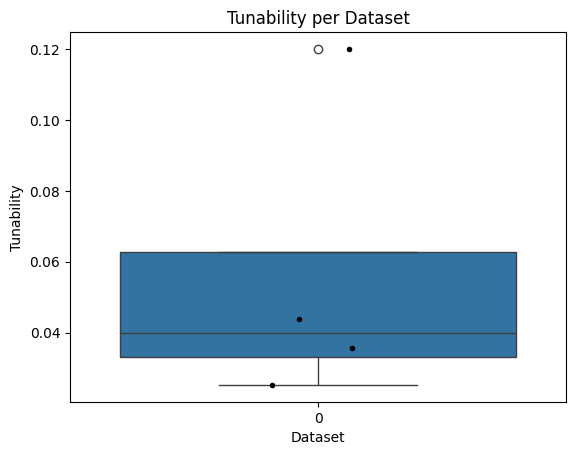

In [24]:
# tunability data
tunability_data = [tunability_on_datasets]

# create box plot
sns.boxplot(data=tunability_data)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per Dataset")

# show the plot
plt.show()

In [25]:
# aggregated tunability d
print("Aggregated tunability d: " + str(np.mean(tunability_on_datasets)))

Aggregated tunability d: 0.05620321736015038


In [26]:
def calculate_scores_for_pipeline(pipeline: Pipeline, train_datasets, test_datasets):
    scores = []
    for train_dataset, test_dataset in zip(train_datasets, test_datasets):
        pipeline.fit(train_dataset[0], train_dataset[1])
        score = pipeline.score(test_dataset[0], test_dataset[1])
        scores.append(score)
        print("score: " + str(score))

In [27]:
calculate_scores_for_pipeline(
    optimal_decision_tree, get_train_datasets(), get_test_datasets()
)

score: 0.9447855527094973
score: 0.06767606198202969
score: 0.45865431353605746
score: 0.6699121131962535


In [28]:
test_scores = (
    []
)  # list of test scores calculated across datasets, for each configuration
config_ids = []
best_config = None
best_test_score = float("-inf")

for i, config in enumerate(configuration_grid_decision_tree):
    results = evaluate_pipeline_on_datasets(
        get_decision_tree_pipeline(), config, train_datasets
    )

    aggregated_test_score = np.mean([result[0] for result in results])
    test_scores.append(aggregated_test_score)
    config_ids.append(i)

    if aggregated_test_score > best_test_score:
        best_test_score = aggregated_test_score
        best_config = config

plt.boxplot(test_scores)
plt.xlabel("Configuration ID")
plt.ylabel("Test Score")
plt.title("Test Scores for Decision Tree")
plt.show()

print("Best Configuration:", best_config)
print("Best Test Score:", best_test_score)

Parameter set: DecisionTreeRegressor(ccp_alpha=0.2, max_depth=6, min_samples_leaf=19,
                      min_samples_split=58)
Test score R^2: 0.7815269691092457
Train score R^2: 0.7815269691092457


Mean Squared Error: 26856.500884781224
Parameter set: DecisionTreeRegressor(ccp_alpha=0.2, max_depth=6, min_samples_leaf=19,
                      min_samples_split=58)
Test score R^2: 0.15528101406816253
Train score R^2: 0.15528101406816253
Mean Squared Error: 9.48162852008955
Parameter set: DecisionTreeRegressor(ccp_alpha=0.2, max_depth=6, min_samples_leaf=19,
                      min_samples_split=58)
Test score R^2: 0.5221465690813645
Train score R^2: 0.5221465690813645
Mean Squared Error: 2903.6276381318785
Parameter set: DecisionTreeRegressor(ccp_alpha=0.2, max_depth=6, min_samples_leaf=19,
                      min_samples_split=58)
Test score R^2: 0.5595820029015193
Train score R^2: 0.5595820029015193
Mean Squared Error: 89991302260.828
Parameter set: DecisionTreeRegressor(max_depth=15, min_samples_leaf=12, min_samples_split=50)
Test score R^2: 0.789919150538415
Train score R^2: 0.789919150538415
Mean Squared Error: 25824.864956727335
Parameter set: DecisionTreeRegressor(max_d

KeyboardInterrupt: 

#### 2. ElasticNet

In [ ]:
def get_elasticnet_pipeline() -> Pipeline:
    elastic_net = ElasticNet(max_iter=10000)
    col_trans: ColumnTransformer = get_column_transformer()
    decision_tree_pipeline = Pipeline(
        steps=[("column_transformer", col_trans), ("model", elastic_net)]
    )
    return decision_tree_pipeline

In [ ]:
def get_parameter_grid_for_elasticnet():
    # parameters space
    random.seed(42)
    alpha = [i * 0.05 for i in range(21)]
    l1_ratio = [i * 0.05 for i in range(21)]
    all_combinations = list(
        itertools.product(
            alpha,
            l1_ratio,
        )
    )
    selected_combinations: List[Tuple[float, int, int, int]] = random.sample(
        all_combinations, 100
    )
    parameter_names = [
        "model__alpha",
        "model__l1_ratio",
    ]

    parameters_grid_elasticnet = [
        dict(zip(parameter_names, combination)) for combination in selected_combinations
    ]
    return parameters_grid_elasticnet

In [ ]:
train_datasets: List[Tuple[DataFrame, Series]] = get_train_datasets()
elastic_net_pipeline: Pipeline = get_elasticnet_pipeline()
parameters_grid_elasticnet = get_parameter_grid_for_elasticnet()
optimal_config_elasticnet = find_optimal_configuration_for_all_datasets(
    config_space=parameters_grid_elasticnet,
    train_datasets=train_datasets,
    model=elastic_net_pipeline,
    summary_func=np.mean,
)

In [ ]:
print(optimal_config_elasticnet)

In [ ]:
evaluate_pipeline_on_datasets(
    get_elasticnet_pipeline(), optimal_config_elasticnet, train_datasets
)

#### 3. Random Forest

In [ ]:
def get_random_forest_pipeline():
    random_forest = RandomForestRegressor()
    col_trans: ColumnTransformer = get_column_transformer()
    random_forest_pipeline = Pipeline(
        steps=[("column_transformer", col_trans), ("model", random_forest)]
    )
    return random_forest_pipeline

In [ ]:
def get_parameter_grid_for_random_forest():
    # parameters space
    random.seed(42)
    max_depth_values = range(1, 31, 1)
    min_samples_split_values = range(2, 61, 1)
    min_samples_leaf_values = range(1, 61, 1)
    n_estimators_values = range(1, 200, 1)

    all_combinations = list(
        itertools.product(
            max_depth_values,
            min_samples_split_values,
            min_samples_leaf_values,
            n_estimators_values,
        )
    )
    selected_combinations: List[Tuple[float, int, int, int]] = random.sample(
        all_combinations, 100
    )
    parameter_names = [
        "model__max_depth",
        "model__min_samples_split",
        "model__min_samples_leaf",
        "model__n_estimators",
    ]

    parameters_grid_random_forest = [
        dict(zip(parameter_names, combination)) for combination in selected_combinations
    ]
    return parameters_grid_random_forest

In [ ]:
train_datasets: List[Tuple[DataFrame, Series]] = get_train_datasets()
random_forest_pipeline: Pipeline = get_random_forest_pipeline()
parameters_grid_random_forest = get_parameter_grid_for_random_forest()

optimal_config_random_forest = find_optimal_configuration_for_all_datasets(
    config_space=parameters_grid_random_forest,
    train_datasets=train_datasets,
    model=random_forest_pipeline,
    summary_func=np.mean,
)

In [ ]:
print(optimal_config_random_forest)

In [ ]:
evaluate_pipeline_on_datasets(
    get_random_forest_pipeline(), optimal_config_random_forest, train_datasets
)

#TODO
- dla każdej konfiguracje z paratmers_grid trzeba ją porównać do optymalnej

### Bayes - decision tree

In [29]:
decision_tree_params = {
    "model__ccp_alpha": Real(0.11, 1.21, prior="log-uniform"),
    "model__max_depth": Integer(1, 31, prior="log-uniform"),
    "model__min_samples_split": Integer(2, 61, prior="log-uniform"),
    "model__min_samples_leaf": Integer(2, 61, prior="log-uniform"),
}

out = get_bayes_best_configuration(
    get_decision_tree_pipeline(),
    [
        (decision_tree_params, 30),
    ],
    X_train_fish_market,
    y_train_fish_market,
    X_test_fish_market,
    y_test_fish_market,
)

print(out[0])
print(out[1])

OrderedDict([('model__ccp_alpha', 0.11), ('model__max_depth', 17), ('model__min_samples_leaf', 2), ('model__min_samples_split', 7)])
30


In [44]:
config = get_bayes_config(
    get_decision_tree_pipeline(),
    [(decision_tree_params, 40)],
    X_train_fish_market,
    y_train_fish_market
)
model = get_decision_tree_pipeline()
model.set_params(**config)
model.fit(X_train_fish_market, y_train_fish_market)
score = model.score(X_test_fish_market, y_test_fish_market)
print(score)

0.9511259336021848
